In [1]:
import numpy as np
import pywt
import scipy as sp
import scipy.fftpack
from scipy import signal, fft
import emd
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from tftb.generators import fmlin
from tftb.processing.cohen import WignerVilleDistribution
import scipy.io
%matplotlib inline
np.set_printoptions(precision=2)
plt.rcParams.update({'font.size': 18})

In [2]:
data = scipy.io.loadmat('Data/vanvikan/imu_measurements_1_2.mat')
imuData_acc = data['imuData'][0][0][0]
print(imuData_acc)

[[ 0.13 -0.05  0.23 ...  0.19  0.1  -0.01]
 [ 0.37  0.16  0.23 ...  0.22  0.22  0.08]
 [ 9.24  8.66  9.8  ... 10.54  9.95  9.24]]


In [3]:
signalx = imuData_acc[0]
signaly = imuData_acc[1]
signalz = imuData_acc[2] - 9.81

In [227]:
fs = 250
resample_rate = 0.4

dt = 1 / fs
N = len(signalx)
t = np.linspace(0,(N-1)*dt, N)

In [49]:
last_n_minutes = 1;
start_idx = last_n_minutes * 250 * 60
#[N-start_idx:N]
print(t[N-start_idx:N])

[911.76 911.76 911.76 ... 971.74 971.75 971.75]


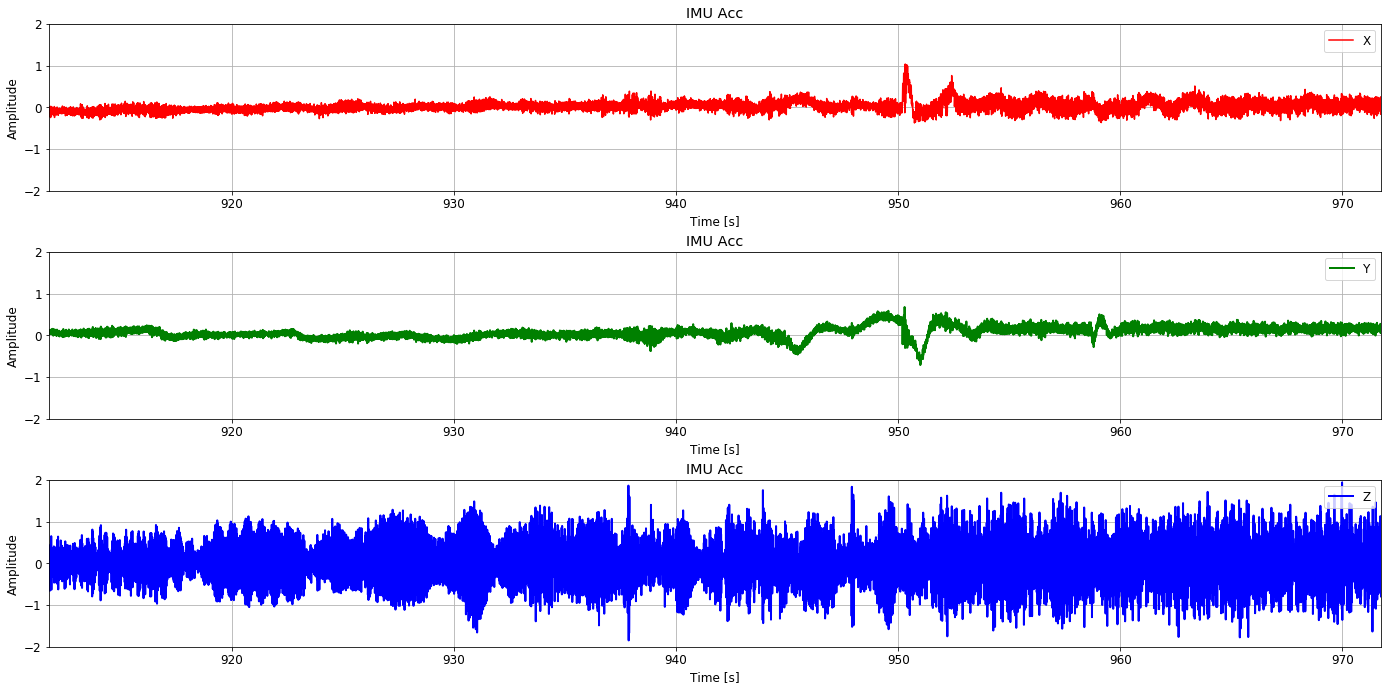

In [71]:
## Plots
fig,axs = plt.subplots(3,1,figsize=(20,10))
fig.tight_layout(pad=3.0)

plt.sca(axs[0])
plt.plot(t[N-start_idx:N],signalx[N-start_idx:N],color='r',linewidth=1.5,label='X')
plt.title('IMU Acc')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.axis([t[N-start_idx:N][0], t[N-start_idx:N][-1],-2,2])
plt.grid()
plt.legend(loc='upper right')

plt.sca(axs[1])
plt.plot(t[N-start_idx:N],signaly[N-start_idx:N],color='g',linewidth=2,label='Y')
plt.title('IMU Acc')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.axis([t[N-start_idx:N][0], t[N-start_idx:N][-1],-2,2])
plt.grid()
plt.legend(loc='upper right')

plt.sca(axs[2])
plt.plot(t[N-start_idx:N],signalz[N-start_idx:N],color='b',linewidth=2,label='Z')
plt.title('IMU Acc')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.axis([t[N-start_idx:N][0], t[N-start_idx:N][-1],-2,2])
plt.grid()
plt.legend(loc='upper right')

plt.savefig('IMU_raw_data.png', bbox_inches='tight')
plt.show()

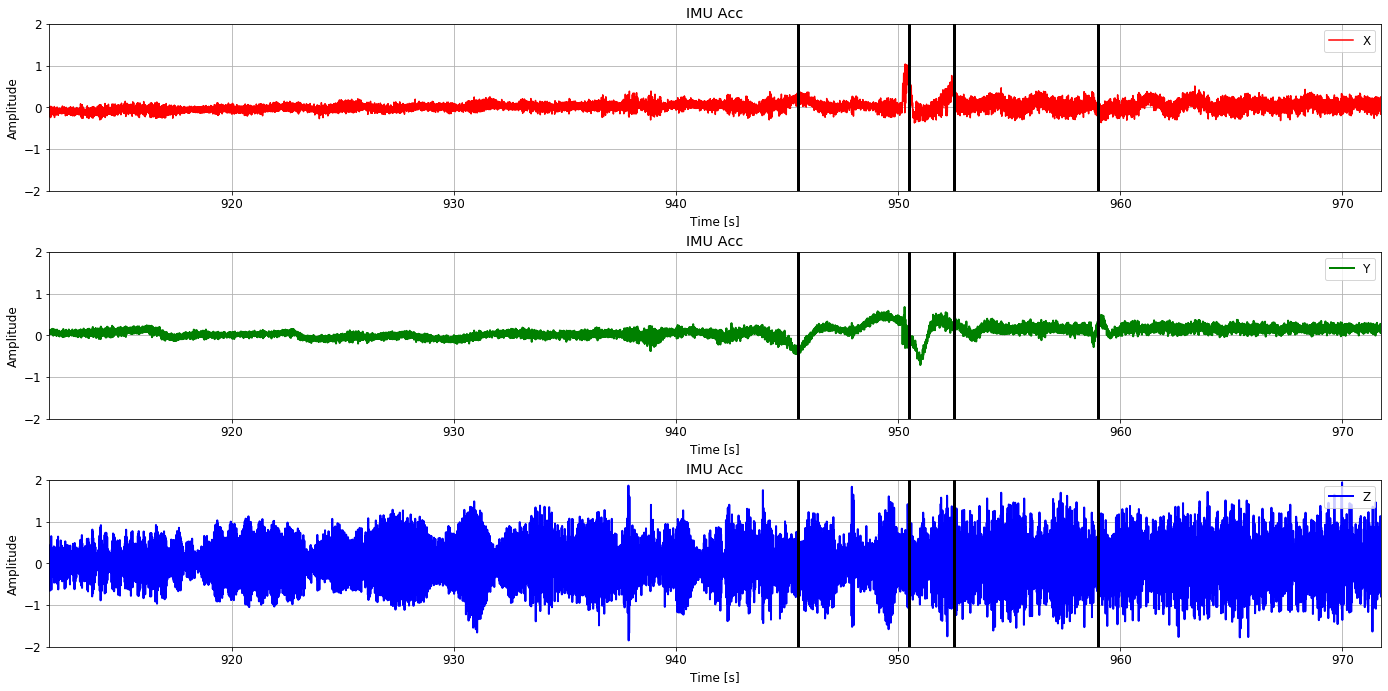

In [75]:
## Plots
fig,axs = plt.subplots(3,1,figsize=(20,10))
fig.tight_layout(pad=3.0)

plt.sca(axs[0])
plt.plot(t[N-start_idx:N],signalx[N-start_idx:N],color='r',linewidth=1.5,label='X')
plt.axvline(x=945.5, ymin=-1, ymax=1, color='k', linewidth=3)
plt.axvline(x=950.5, ymin=-1, ymax=1, color='k', linewidth=3)
plt.axvline(x=952.5, ymin=-1, ymax=1, color='k', linewidth=3)
plt.axvline(x=959, ymin=-1, ymax=1, color='k', linewidth=3)
plt.title('IMU Acc')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.axis([t[N-start_idx:N][0], t[N-start_idx:N][-1],-2,2])
plt.grid()
plt.legend(loc='upper right')

plt.sca(axs[1])
plt.plot(t[N-start_idx:N],signaly[N-start_idx:N],color='g',linewidth=2,label='Y')
plt.axvline(x=945.5, ymin=-1, ymax=1, color='k', linewidth=3)
plt.axvline(x=950.5, ymin=-1, ymax=1, color='k', linewidth=3)
plt.axvline(x=952.5, ymin=-1, ymax=1, color='k', linewidth=3)
plt.axvline(x=959, ymin=-1, ymax=1, color='k', linewidth=3)
plt.title('IMU Acc')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.axis([t[N-start_idx:N][0], t[N-start_idx:N][-1],-2,2])
plt.grid()
plt.legend(loc='upper right')

plt.sca(axs[2])
plt.plot(t[N-start_idx:N],signalz[N-start_idx:N],color='b',linewidth=2,label='Z')
plt.axvline(x=945.5, ymin=-1, ymax=1, color='k', linewidth=3)
plt.axvline(x=950.5, ymin=-1, ymax=1, color='k', linewidth=3)
plt.axvline(x=952.5, ymin=-1, ymax=1, color='k', linewidth=3)
plt.axvline(x=959, ymin=-1, ymax=1, color='k', linewidth=3)
plt.title('IMU Acc')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.axis([t[N-start_idx:N][0], t[N-start_idx:N][-1],-2,2])
plt.grid()
plt.legend(loc='upper right')

plt.savefig('IMU_raw_data_w_collisions.png', bbox_inches='tight')
plt.show()

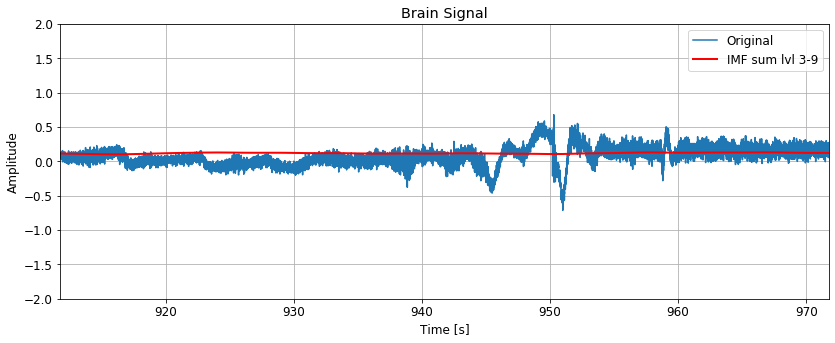

In [175]:
### LP
import numpy as np
from scipy.signal import butter, lfilter, freqz

cutoff = 10
fs = 250

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(signaly[N-start_idx:N], cutoff, fs, order=2)

fig,axs = plt.subplots(1,1,figsize=(12, 5))
fig.tight_layout(pad=2.5)

plt.sca(axs)
plt.plot(t[N-start_idx:N],signaly[N-start_idx:N])
plt.plot(y, color='r', linewidth=2)
plt.grid()
plt.title('Brain Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time [s]')
plt.gca().legend(('Original','IMF sum lvl 3-9'))
plt.axis([t[N-start_idx:N][0], t[N-start_idx:N][-1],-2,2])
#plt.savefig('IMF_vs_orig.png', bbox_inches='tight')
plt.show()

<Figure size 936x576 with 0 Axes>

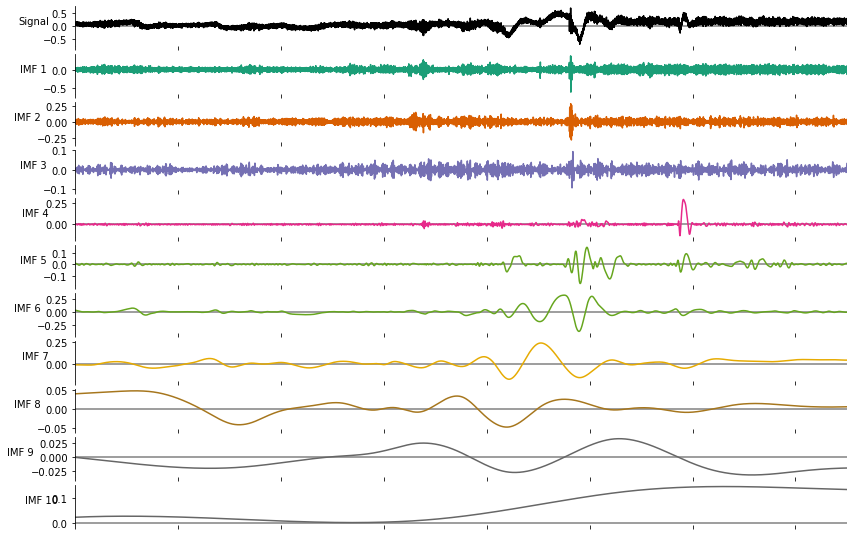

<Figure size 936x576 with 0 Axes>

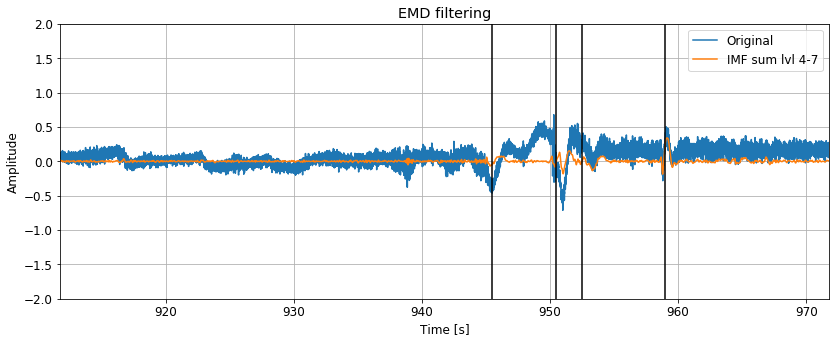

In [251]:
## EMD
plt.rcParams.update({'font.size': 10})

fig_1 = plt.figure(figsize=(13, 8))
fig_2 = plt.figure(figsize=(13, 8))
fig_3 = plt.figure(figsize=(13, 8))

imf_y = emd.sift.sift(signaly[N-start_idx:N], max_imfs=15)
emd.plotting.plot_imfs(imf_y, scale_y=False, cmap=True, fig=fig_2)
'''
imf_x = emd.sift.sift(signalx[N-start_idx:N], max_imfs=15)
emd.plotting.plot_imfs(imf_x, scale_y=False, cmap=True, fig=fig_1)

imf_z = emd.sift.sift(signalz[N-start_idx:N], max_imfs=15)
emd.plotting.plot_imfs(imf_z, scale_y=False, cmap=True, fig=fig_3)
'''

plt.rcParams.update({'font.size': 12})

# Adding imf's to see what we can extract
IMF_y = imf_y[:,3]
for i in range(4,5):
    IMF_y +=  imf_y[:,i]
    
fig,axs = plt.subplots(1,1,figsize=(12, 5))
fig.tight_layout(pad=2.5)

plt.sca(axs)
plt.plot(t[N-start_idx:N], signaly[N-start_idx:N])
plt.plot(t[N-start_idx:N], IMF_y)
plt.axvline(x=945.5, ymin=-1, ymax=1, color='k', linewidth=1.5)
plt.axvline(x=950.5, ymin=-1, ymax=1, color='k', linewidth=1.5)
plt.axvline(x=952.5, ymin=-1, ymax=1, color='k', linewidth=1.5)
plt.axvline(x=959.0, ymin=-1, ymax=1, color='k', linewidth=1.5)
plt.grid()
plt.title('EMD filtering')
plt.ylabel('Amplitude')
plt.xlabel('Time [s]')
plt.axis([t[N-start_idx:N][0], t[N-start_idx:N][-1],-2,2])
plt.gca().legend(('Original','IMF sum lvl 4-7'))
plt.savefig('EMD_vs_orig.png', bbox_inches='tight')
plt.show()

Scale to frequency conversion: [100, 300] -> [1.75 0.58] Hz


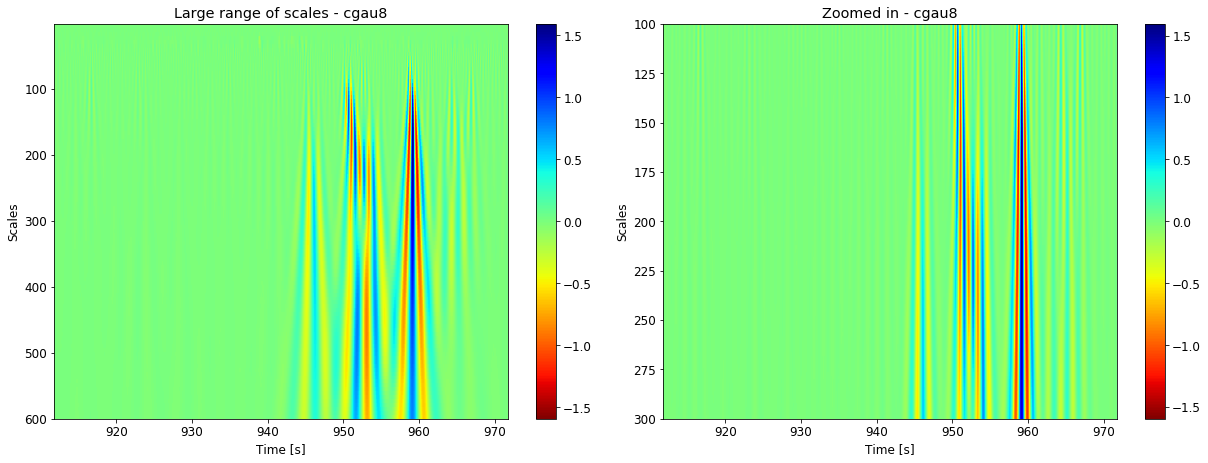

Scale to frequency conversion: [100, 300] -> [2.03 0.68] Hz


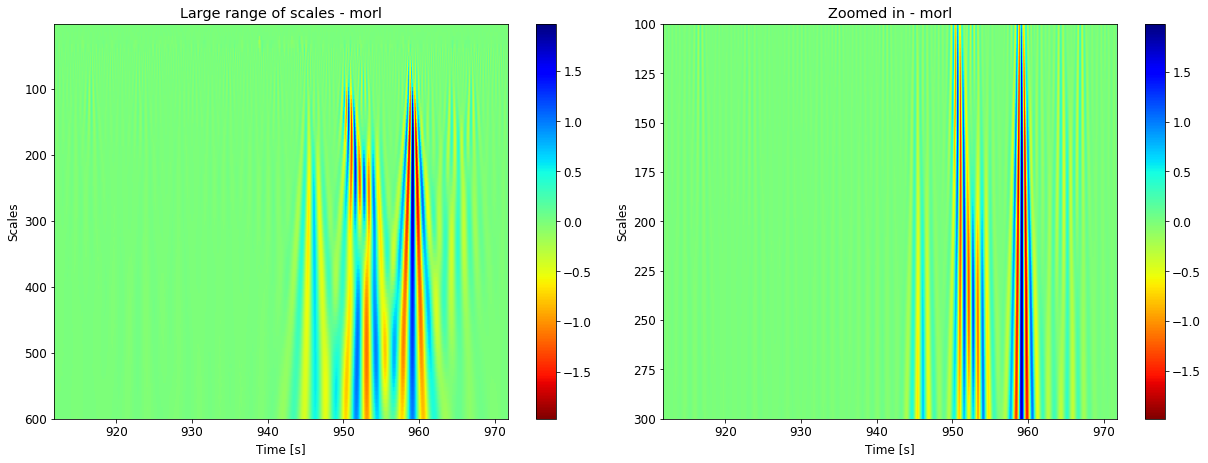

Scale to frequency conversion: [100, 300] -> [1.94 0.65] Hz


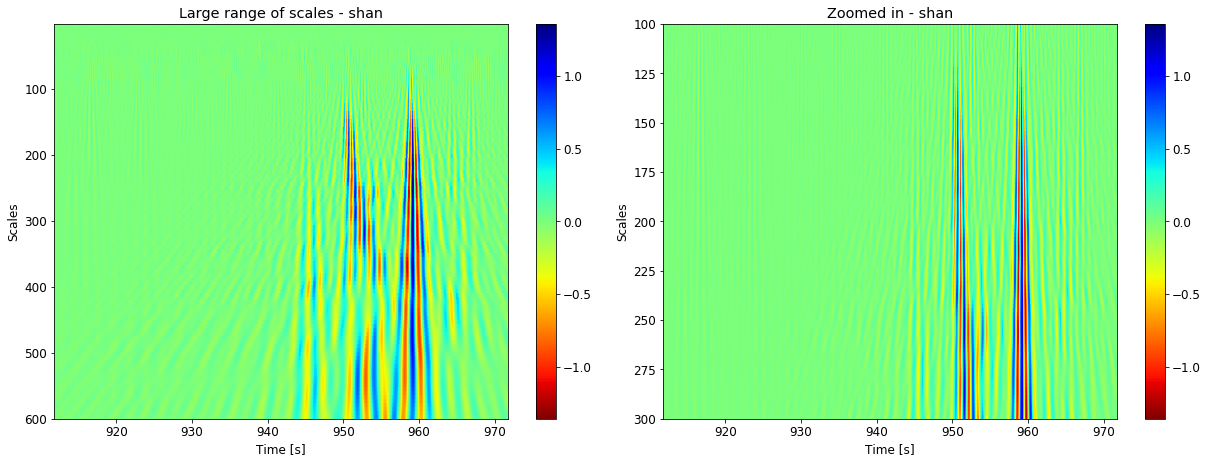

In [252]:
## CWT
scales_1 = np.linspace(1, 600, 100)
scales_2 = np.linspace(100, 300, 100)
#scales = [7, 8, 9, 10, 12]
waveletname = 'mexh'
scales_to_freq = [100,300]
freqs = pywt.scale2frequency(waveletname, scales_to_freq) / dt
#print(pywt.wavelist(kind='continuous'))
#print(f"Scale to frequency conversion: {scales_to_freq} -> {freqs} Hz")

wavelet_list = [ 'cgau8', 'morl', 'shan']

for waveletname in wavelet_list:
    freqs = pywt.scale2frequency(waveletname, scales_to_freq) / dt
    print(f"Scale to frequency conversion: {scales_to_freq} -> {freqs} Hz")

    fig,axs = plt.subplots(1,2,figsize=(17, 6))
    fig.tight_layout(pad=0.5)

    plt.sca(axs[0])
    cwtmatr, freqs = pywt.cwt(IMF_y, scales_1, waveletname)
    plt.imshow(cwtmatr.real, extent=[t[N-start_idx], t[N-1], scales_1[-1], scales_1[0]], cmap='jet_r', aspect='auto',
               vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max()) 
    plt.title(f"Large range of scales - {waveletname}")
    plt.ylabel('Scales')
    plt.xlabel('Time [s]')
    plt.colorbar()

    plt.sca(axs[1])
    cwtmatr, freqs = pywt.cwt(IMF_y, scales_2, waveletname)
    plt.imshow(cwtmatr.real, extent=[t[N-start_idx], t[N-1], scales_2[-1], scales_2[0]], cmap='jet_r', aspect='auto',
               vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max()) 
    plt.title(f"Zoomed in - {waveletname}")
    plt.ylabel('Scales')
    plt.xlabel('Time [s]')
    plt.colorbar()
    plt.savefig('CWT_cgaug8.png', bbox_inches='tight')
    plt.show()

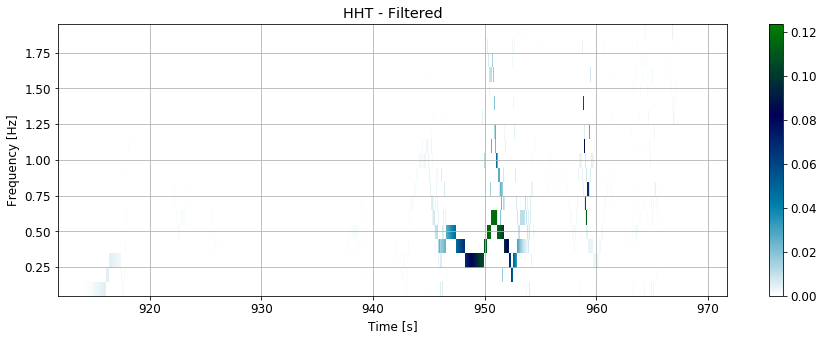

In [242]:
IP, IF, IA = emd.spectra.frequency_stats(imf_y[:,3:6], fs, 'nht') # method : {‘hilbert’,’quad’,’direct_quad’,’nht’}
freq_edges, freq_bins = emd.spectra.define_hist_bins(0, 2, 20)
hht = emd.spectra.hilberthuang(infr=IF, inam=IA, freq_edges=freq_edges, mode='energy', return_sparse=False)

plt.figure(figsize=(15, 5))
#plt.subplot(1, 1, 1)
plt.pcolormesh(t[N-start_idx:N], freq_bins, hht, cmap='ocean_r')
plt.title('HHT - Filtered')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.grid()
plt.colorbar()
plt.savefig('HHT_filtered.png', bbox_inches='tight')
plt.show()

61
15000


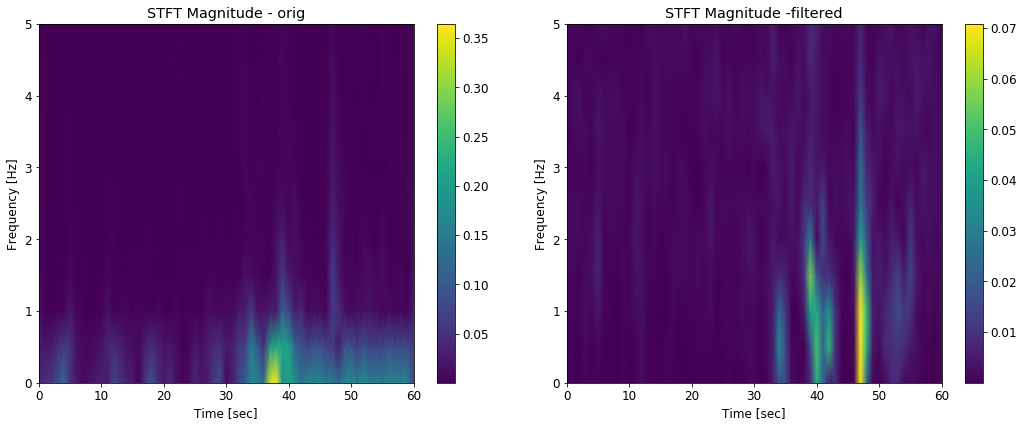

In [253]:
# STFT
yhat, tm, Zxx = signal.stft(signaly[N-start_idx:N], fs, window='hann',nperseg=500)
yhat_filt, tm_filt, Zxx_filt = signal.stft(IMF_y, fs, window='hann',nperseg=500)

print(tm.size)
print(len(t[N-start_idx:N]))

fig,axs = plt.subplots(1,2,figsize=(15, 6))
fig.tight_layout(pad=2.0)

plt.sca(axs[0])
plt.pcolormesh(tm, yhat, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude - orig')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.axis([0,60,0,5])
plt.colorbar()

plt.sca(axs[1])
plt.pcolormesh(tm_filt, yhat_filt, np.abs(Zxx_filt), shading='gouraud')
plt.title('STFT Magnitude -filtered')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.axis([0,60,0,5])
plt.colorbar()
plt.show()